# Exploratory data analysis (2)


# Part 2: Connecting word count, Zipf's law and TF-IDF

In the previous chapter we detected a bunch of data corruption using word count.

In this chapter we will continue using word count and will explain:
 * why further data cleaning is still necessary
 * why TF-IDF is a good start for the given dataset (after cleaning)

The dataset file was not uploaded to this github repo for information safety consideration.

In [1]:
import pandas as pd

df_sku = pd.read_json('exercise2.jl', lines=True)

**We start with removing corrupted data from the dataset**

According to previous chapter, the dataset was corrupted.

A description text containing 19 words were repeated for 6000 times (over 23% of the dataset).

This will pollute the statistic result, we want to get rid of it.

In [2]:
def word_count(text):
    return len(text.split())

df_sku['long_desc_wc'] = df_sku['long_description'].apply(word_count)
df_sku_clean = df_sku[df_sku['long_desc_wc'] != 19]

**Next we build a vocaburary from all product descriptions**

In [3]:
# Extract all text from `long_description` column to an python array
long_desc_array = df_sku_clean['long_description'].values.tolist()

# Merge all text in the array to a long text buffer
long_desc = ' '.join(long_desc_array)

# Split the text buffer to a list of words
desc_words = long_desc.split()

# Convert the list of words to a pandas dataframe for further analysis
desc_vocabulary = pd.DataFrame({'word': desc_words})

In [4]:
desc_vocabulary

,word
0,<p>Multicoloured
1,laptop
2,bag
3,detailed
4,with
...,...
1036857,regular
1036858,fit.
1036859,Composition:
1036860,100%


**Now it's time to perform another word count**

In [5]:
desc_vocabulary_wc = desc_vocabulary.value_counts().reset_index('word', name='cnt')
desc_vocabulary_wc

,word,cnt
0,and,31276
1,the,22905
2,a,21549
3,in,16400
4,with,15850
...,...,...
58159,edges<br>Rear,1
58160,edges<br>Purple,1
58161,FAMF-WC7</li>,1
58162,edges<br>Lil,1


**Let's have a look at the distribution of the vocabulary**

array([[<AxesSubplot:title={'center':'cnt'}>]], dtype=object)

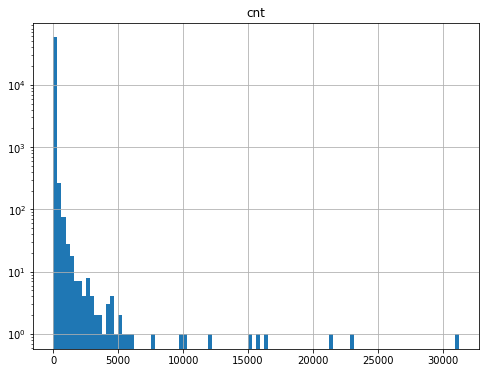

In [6]:
# Log chart works better for extremely unbalanced distribution
desc_vocabulary_wc.hist(bins=100, log=True, figsize=(8,6))

**Important observations**

Further investigation reveals following insights:

 * The vocabulary has an extremely unbalanced distribution.
 * Tokens in the head appear 10,000 more frequent than tokens in the tail.
 * Head tokens are **stop words** like `and`, `the`, `a`, `in`, `with`
 * Tail tokens are gabage like `FAIB-WC31`
 * html tags like `<br>` also generates significant noise
 * Similar analysis applying on char level shows puntuctuation are another important source of noise

**Above analysis shows the importance of the following preprocessing steps**

 * Stop word removal
 * Feature reduction, discard tail tokens
 * HTML tag removal
 * Puntuctuation removal
 
Lack of any above step will cause significant harm in downstream tasks.

### Why TF-IDF?

It's widely known that TF-IDF is commonly used in NLP tasks, but it's not obvious why use TF-IDF.

This section introduces an important empirical law observed in natural language corpus:

 * [**Zipf's law**](https://en.wikipedia.org/wiki/Zipf%27s_law)

After that we will test whether our dataset follows **Zipf's law**

Finally we will present a high level intuition connecting **TF-IDF** and a slightly different variant of **Zipf's law**

**Zipf’s law states that the frequency that a word appears is inversely proportional to its rank.**

On a log-log scale plot, Zipf's law looks like a straight line with negative slope.

Here is a plot of the rank versus frequency for the first 10 million words in 30 Wikipedias in a log-log scale.

According to the plot, Wikipedia corpus fits Zipf's law pretty well.

<img src="https://github.com/fracting/sku-clustering/raw/main/images/Zipf_30wiki_en_labels.png" width="550" align="left">


**Now we can have a look at our own dataset**

<AxesSubplot:xlabel='Rank', ylabel='cnt'>

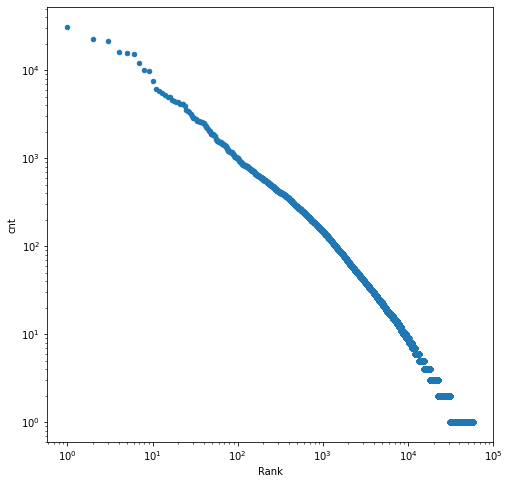

In [8]:
import math
desc_vocabulary_wc['Rank'] = desc_vocabulary_wc.index + 1
desc_vocabulary_wc.plot.scatter(x='Rank', y='cnt',loglog=True, figsize=(8,8))

**Comparing with the Wikipedia corpus, we can see the given dataset also fits Zipf's law pretty well**

**Now we try to connect Zipf's law and TF-IDF in an intuitive way**

<img src="https://github.com/fracting/sku-clustering/raw/main/images/TF_IDF.png" width="550" align="left">


Intuitively, for any corpus follows Zipf's law, the frequency of top tokens are multiple orders of magnitude higher than the frequency of tail tokens.

Informally speaking, the logarithm function used in **IDF** will squash this huge gap into a linear scale, which works much better for scoring algorithm.

**A callback to chapter 1**

In the previous chapter, we applied word count on each row of the `long_description` column.

In this chapter, we applied word count on the whole `long_description` column.

If we think carefully about how TF-IDF is calculated:
 * the `TF` part requires counting number of token in each document, in our case every row is a document.
 * the `IDF` part requires counting number of token in the whole dataset, in our case it means the entire row.
    
At this point we connect all the dots between data science 101 (word count) and NLP 101 (TF-IDF)!

Essentially, TF-IDF is an application of word count in multiple ways.

And that leads us to the key point to our exploratory data analysis:

We want to validate that the data source we plan to use for TF-IDF is not surprising, and by applying word count on row level and column level, we extracted important information we need.

In other words, no single step is arbitrary in our analysis, they all have a reason, and our investment made a good return as shown in this report.

### Conclusion

**Previous chapter is important**, because:

 * It points out the data corruption problem in the dataset
 * It validates the `TF` part of TF-IDF
 
**This chapter is important**, because:
 * It points out several further data cleaning and preprocessing steps required
 * It validates the `IDF` part of TF-IDF

After proper preprocessing, we can see the clean dataset satisfies usage requirement of TF-IDF
 
These data analysis works establish a solid foundation for downstream tasks.

Unfortunately, as we introduced in [**README.md**](https://github.com/fracting/sku-clustering#readme), TF-IDF didn't perform outstandingly as expected.

For example the class contains `Jumpsuit` and the class contains `Polo` are likely to mix with each other.

For the time limit we don't show details of the TF-IDF model, what **we want to emphasize** is:

 * With solid data analysis, we can build certain level of confidence for the machine learning algorithm we chose for the given dataset.
 * If there's nothing wrong with the algorithm (TF-IDF in this case) but the outcome is not great, then we have the confidence to suspect that there exists even more subtle and interesting **characteristics hiding in the given dataset**.
 
We will leave it as a puzzle for now, and revisit it in the last chapter.

**Next chapter presents another approach based on word embedding**